# **Machine Learning Model Comparison**
From the baseline model evaluations, the data appeared to be imbalanced, underampling was used to balance the data.

Six different models were used:


*   Logistic Regression.
*   Decision Tree.
*   Random Forest.
*   XGBoost.
*   Lasso.
*   SVM.

Hyperparameter optimisation was performed through grid search for XGboost (best performing model).

A stacking ensembled  model and a DNN were executed and evaluated.

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# Read dataset
df = pd.read_csv('/content/drive/MyDrive/Predictive Analysis/Predictive Analysis CA/Data/Balanced_Data.csv')

In [ ]:
# Display head
df.head()

In [ ]:
# Count of rows and columns
df.shape

(1048575, 26)

# **Logical Regression**

In [ ]:
# Extract numeric time from 'DEP_TIME_BLK'
df['DEP_TIME_START'] = df['DEP_TIME_BLK'].str.split('-').str[0].astype(int)

# Convert categorical variables into numerical values
label_encoder = LabelEncoder()

# Example: Encoding 'CARRIER_NAME' and 'DEPARTING_AIRPORT'
df['CARRIER_NAME'] = label_encoder.fit_transform(df['CARRIER_NAME'])
df['DEPARTING_AIRPORT'] = label_encoder.fit_transform(df['DEPARTING_AIRPORT'])

# Handle missing values
df = df.dropna()

# Select features and target variable
X = df[['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_START', 'DISTANCE_GROUP',
        'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
        'AIRPORT_FLIGHTS_MONTH', 'PLANE_AGE', 'LATITUDE', 'LONGITUDE',
        'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']]  # Add or remove features as necessary

# Target variable
y = df['DEP_DEL15']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test_scaled)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6041618320707753
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.60      0.60    157229
           1       0.60      0.61      0.61    157344

    accuracy                           0.60    314573
   macro avg       0.60      0.60      0.60    314573
weighted avg       0.60      0.60      0.60    314573

Confusion Matrix:
 [[94172 63057]
 [61463 95881]]


**Threshold Tuning for Logistic Regression**

Highest F1 Score on Test Set: 0.6774920979383875
Optimal Threshold: 0.36


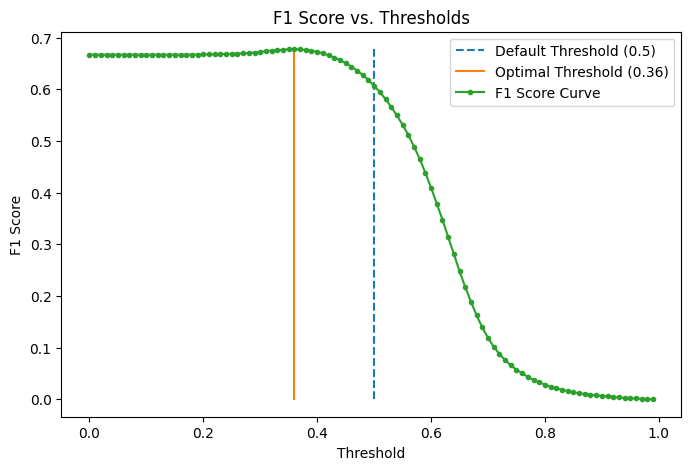

Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.71      0.22      0.33    157229
           1       0.54      0.91      0.68    157344

    accuracy                           0.57    314573
   macro avg       0.63      0.57      0.51    314573
weighted avg       0.63      0.57      0.51    314573

Confusion Matrix with Optimal Threshold:
 [[ 34241 122988]
 [ 13736 143608]]


In [ ]:
# Get probabilities for the positive class
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Threshold tuning for F1 score
highest_f1 = 0
optimal_threshold = 0

thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_custom = (y_pred_prob >= t).astype(int)
    score = f1_score(y_test, y_pred_custom)
    f1_scores.append(score)
    if score > highest_f1:
        highest_f1 = score
        optimal_threshold = t

# Print results
print("Highest F1 Score on Test Set:", highest_f1)
print("Optimal Threshold:", optimal_threshold)

# Plot F1 score vs. thresholds
plt.figure(figsize=(8, 5))
plt.plot([0.5, 0.5], [min(f1_scores), max(f1_scores)], linestyle='--', label="Default Threshold (0.5)")
plt.plot([optimal_threshold, optimal_threshold], [min(f1_scores), max(f1_scores)], linestyle='-', label=f"Optimal Threshold ({optimal_threshold:.2f})")
plt.plot(thresholds, f1_scores, marker='.', label="F1 Score Curve")
plt.title('F1 Score vs. Thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Evaluate model with the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Final evaluation metrics
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))


**F1 Score Tuning for Logistic Regression**

Highest F1 Score on Test Set: 0.6774920979383875
Optimal Threshold: 0.36


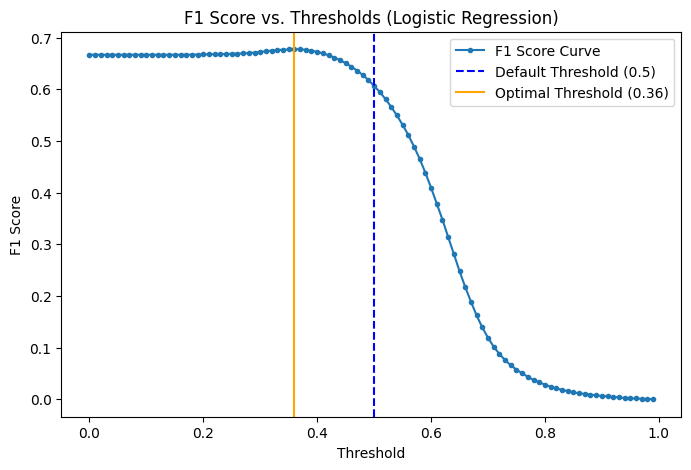

Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.71      0.22      0.33    157229
           1       0.54      0.91      0.68    157344

    accuracy                           0.57    314573
   macro avg       0.63      0.57      0.51    314573
weighted avg       0.63      0.57      0.51    314573

Confusion Matrix with Optimal Threshold:
 [[ 34241 122988]
 [ 13736 143608]]


In [ ]:
# Get probabilities for the positive class
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# F1 score tuning
highest_f1 = 0
optimal_threshold = 0

thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_custom = (y_pred_prob >= t).astype(int)
    score = f1_score(y_test, y_pred_custom)
    f1_scores.append(score)
    if score > highest_f1:
        highest_f1 = score
        optimal_threshold = t

# Print results
print("Highest F1 Score on Test Set:", highest_f1)
print("Optimal Threshold:", optimal_threshold)

# Plot F1 score vs. thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='.', label="F1 Score Curve")
plt.axvline(x=0.5, color='blue', linestyle='--', label="Default Threshold (0.5)")
plt.axvline(x=optimal_threshold, color='orange', linestyle='-', label=f"Optimal Threshold ({optimal_threshold:.2f})")
plt.title('F1 Score vs. Thresholds (Logistic Regression)')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Evaluate model with the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Final evaluation metrics
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))


# **DecisionTreeClassifier**

In [ ]:
# Extract numeric time from 'DEP_TIME_BLK'
df['DEP_TIME_START'] = df['DEP_TIME_BLK'].str.split('-').str[0].astype(int)

# Convert categorical variables into numerical values
label_encoder = LabelEncoder()

# Example: Encoding 'CARRIER_NAME' and 'DEPARTING_AIRPORT'
df['CARRIER_NAME'] = label_encoder.fit_transform(df['CARRIER_NAME'])
df['DEPARTING_AIRPORT'] = label_encoder.fit_transform(df['DEPARTING_AIRPORT'])

# Handle missing values
df = df.dropna()

# Select features and target variable
X = df[['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_START', 'DISTANCE_GROUP',
        'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
        'AIRPORT_FLIGHTS_MONTH', 'PLANE_AGE', 'LATITUDE', 'LONGITUDE',
        'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']]

# Target variable
y = df['DEP_DEL15']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Decision Tree Classifier model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test_scaled)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5845288692926602
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.59      0.58    157229
           1       0.58      0.58      0.58    157344

    accuracy                           0.58    314573
   macro avg       0.58      0.58      0.58    314573
weighted avg       0.58      0.58      0.58    314573

Confusion Matrix:
 [[92076 65153]
 [65543 91801]]


**Threshold tuning For DecisionTreeClassifier**

Highest F1 Score on Test Set: 0.6668291246130146
Optimal Threshold: 0.0


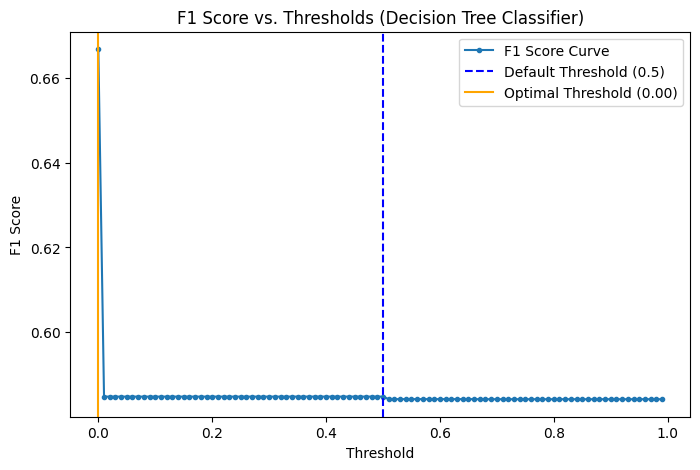

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    157229
           1       0.50      1.00      0.67    157344

    accuracy                           0.50    314573
   macro avg       0.25      0.50      0.33    314573
weighted avg       0.25      0.50      0.33    314573

Confusion Matrix with Optimal Threshold:
 [[     0 157229]
 [     0 157344]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Get probabilities for the positive class
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Threshold tuning for F1 score
highest_f1 = 0
optimal_threshold = 0

thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_custom = (y_pred_prob >= t).astype(int)
    score = f1_score(y_test, y_pred_custom)
    f1_scores.append(score)
    if score > highest_f1:
        highest_f1 = score
        optimal_threshold = t

# Print results
print("Highest F1 Score on Test Set:", highest_f1)
print("Optimal Threshold:", optimal_threshold)

# Plot F1 score vs. thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='.', label="F1 Score Curve")
plt.axvline(x=0.5, color='blue', linestyle='--', label="Default Threshold (0.5)")
plt.axvline(x=optimal_threshold, color='orange', linestyle='-', label=f"Optimal Threshold ({optimal_threshold:.2f})")
plt.title('F1 Score vs. Thresholds (Decision Tree Classifier)')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Evaluate model with the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Final evaluation metrics
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))


**F1 Score Tuning For DecisionTreeClassifier**

Highest F1 Score on Test Set: 0.6668291246130146
Optimal Threshold for F1 Score: 0.0


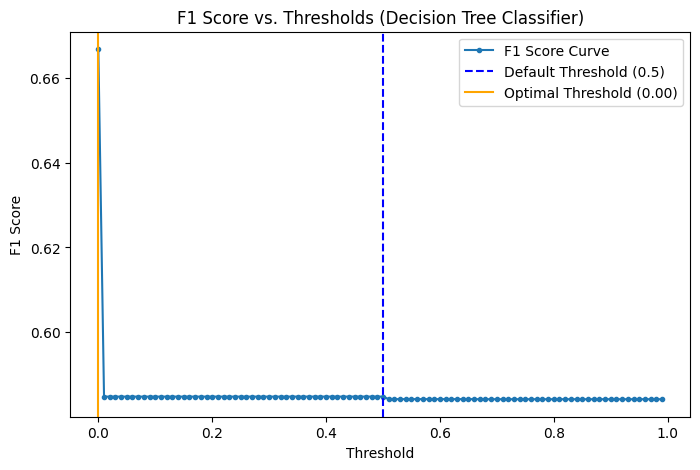

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    157229
           1       0.50      1.00      0.67    157344

    accuracy                           0.50    314573
   macro avg       0.25      0.50      0.33    314573
weighted avg       0.25      0.50      0.33    314573

Confusion Matrix with Optimal Threshold:
 [[     0 157229]
 [     0 157344]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Get probabilities for the positive class
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# F1 Score Tuning
highest_f1 = 0
optimal_threshold = 0

thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_custom = (y_pred_prob >= t).astype(int)
    score = f1_score(y_test, y_pred_custom)
    f1_scores.append(score)
    if score > highest_f1:
        highest_f1 = score
        optimal_threshold = t

# Print results
print("Highest F1 Score on Test Set:", highest_f1)
print("Optimal Threshold for F1 Score:", optimal_threshold)

# Plot F1 score vs. thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='.', label="F1 Score Curve")
plt.axvline(x=0.5, color='blue', linestyle='--', label="Default Threshold (0.5)")
plt.axvline(x=optimal_threshold, color='orange', linestyle='-', label=f"Optimal Threshold ({optimal_threshold:.2f})")
plt.title('F1 Score vs. Thresholds (Decision Tree Classifier)')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Evaluate model with the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Final evaluation metrics
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))


# **Random Forest**

In [ ]:
# Extract numeric time from 'DEP_TIME_BLK'
df['DEP_TIME_START'] = df['DEP_TIME_BLK'].str.split('-').str[0].astype(int)

# Convert categorical variables into numerical values
label_encoder = LabelEncoder()

# Example: Encoding 'CARRIER_NAME' and 'DEPARTING_AIRPORT'
df['CARRIER_NAME'] = label_encoder.fit_transform(df['CARRIER_NAME'])
df['DEPARTING_AIRPORT'] = label_encoder.fit_transform(df['DEPARTING_AIRPORT'])

# Handle missing values
df = df.dropna()

# Select features and target variable
X = df[['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_START', 'DISTANCE_GROUP',
        'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
        'AIRPORT_FLIGHTS_MONTH', 'PLANE_AGE', 'LATITUDE', 'LONGITUDE',
        'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']]

# Target variable
y = df['DEP_DEL15']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Forest Classifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters here
model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test_scaled)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6513464283330102
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66    157229
           1       0.66      0.63      0.64    157344

    accuracy                           0.65    314573
   macro avg       0.65      0.65      0.65    314573
weighted avg       0.65      0.65      0.65    314573

Confusion Matrix:
 [[105503  51726]
 [ 57951  99393]]


**Threshold Tuning For Random Forest**

Highest F1 Score on Test Set: 0.690437257003967
Optimal Threshold for F1 Score: 0.32


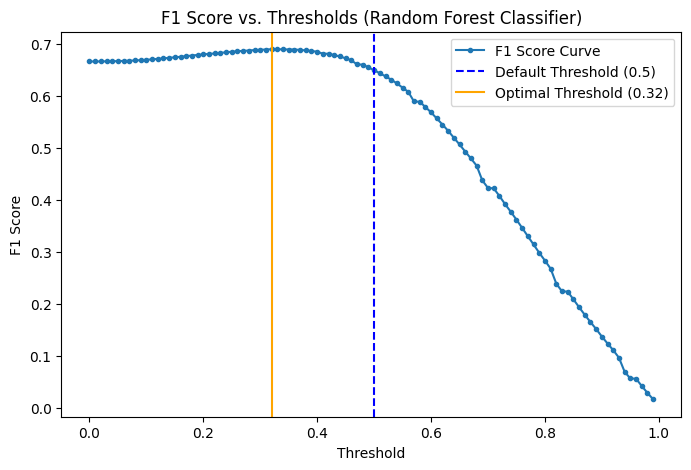

Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.74      0.31      0.44    157229
           1       0.56      0.89      0.69    157344

    accuracy                           0.60    314573
   macro avg       0.65      0.60      0.57    314573
weighted avg       0.65      0.60      0.57    314573

Confusion Matrix with Optimal Threshold:
 [[ 49490 107739]
 [ 17585 139759]]


In [ ]:
# Get probabilities for the positive class
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# F1 Score Tuning
highest_f1 = 0
optimal_threshold = 0

thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_custom = (y_pred_prob >= t).astype(int)
    score = f1_score(y_test, y_pred_custom)
    f1_scores.append(score)
    if score > highest_f1:
        highest_f1 = score
        optimal_threshold = t

# Print results
print("Highest F1 Score on Test Set:", highest_f1)
print("Optimal Threshold for F1 Score:", optimal_threshold)

# Plot F1 score vs. thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='.', label="F1 Score Curve")
plt.axvline(x=0.5, color='blue', linestyle='--', label="Default Threshold (0.5)")
plt.axvline(x=optimal_threshold, color='orange', linestyle='-', label=f"Optimal Threshold ({optimal_threshold:.2f})")
plt.title('F1 Score vs. Thresholds (Random Forest Classifier)')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Evaluate model with the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Final evaluation metrics
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))


**F1 Score Tuning For Random Forest**

Highest F1 Score on Test Set: 0.690437257003967
Optimal Threshold for F1 Score: 0.32


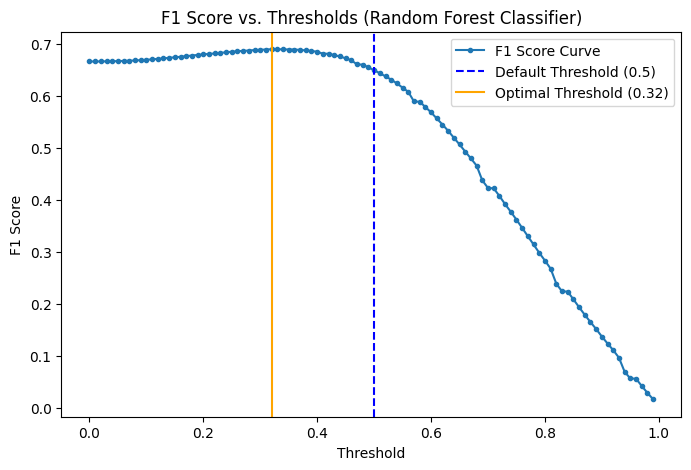

Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.74      0.31      0.44    157229
           1       0.56      0.89      0.69    157344

    accuracy                           0.60    314573
   macro avg       0.65      0.60      0.57    314573
weighted avg       0.65      0.60      0.57    314573

Confusion Matrix with Optimal Threshold:
 [[ 49490 107739]
 [ 17585 139759]]


In [ ]:
# Get probabilities for the positive class
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Initialize variables for F1 score tuning
highest_f1 = 0
optimal_threshold = 0

# Define a range of thresholds to test
thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_custom = (y_pred_prob >= t).astype(int)
    score = f1_score(y_test, y_pred_custom)
    f1_scores.append(score)
    if score > highest_f1:
        highest_f1 = score
        optimal_threshold = t

# Print the highest F1 score and the optimal threshold
print("Highest F1 Score on Test Set:", highest_f1)
print("Optimal Threshold for F1 Score:", optimal_threshold)

# Plot F1 score vs. thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='.', label="F1 Score Curve")
plt.axvline(x=0.5, color='blue', linestyle='--', label="Default Threshold (0.5)")
plt.axvline(x=optimal_threshold, color='orange', linestyle='-', label=f"Optimal Threshold ({optimal_threshold:.2f})")
plt.title('F1 Score vs. Thresholds (Random Forest Classifier)')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Evaluate the model with the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Final evaluation metrics
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))


# **XGboost**

In [ ]:
# Extract numeric time from 'DEP_TIME_BLK'
df['DEP_TIME_START'] = df['DEP_TIME_BLK'].str.split('-').str[0].astype(int)

# Convert categorical variables into numerical values
label_encoder = LabelEncoder()

# Example: Encoding 'CARRIER_NAME' and 'DEPARTING_AIRPORT'
df['CARRIER_NAME'] = label_encoder.fit_transform(df['CARRIER_NAME'])
df['DEPARTING_AIRPORT'] = label_encoder.fit_transform(df['DEPARTING_AIRPORT'])

# Handle missing values
df = df.dropna()

# Select features and target variable
X = df[['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_START', 'DISTANCE_GROUP',
        'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
        'AIRPORT_FLIGHTS_MONTH', 'PLANE_AGE', 'LATITUDE', 'LONGITUDE',
        'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']]  # Add or remove features as necessary

# Target variable
y = df['DEP_DEL15']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost model
model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test_scaled)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:43:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6582224157826642
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66    157229
           1       0.66      0.65      0.65    157344

    accuracy                           0.66    314573
   macro avg       0.66      0.66      0.66    314573
weighted avg       0.66      0.66      0.66    314573

Confusion Matrix:
 [[105545  51684]
 [ 55830 101514]]


**Threshold Tuning For XGboost**

Highest Accuracy on Test Set: 0.6582224157826642
Threshold for Highest Accuracy: 0.5


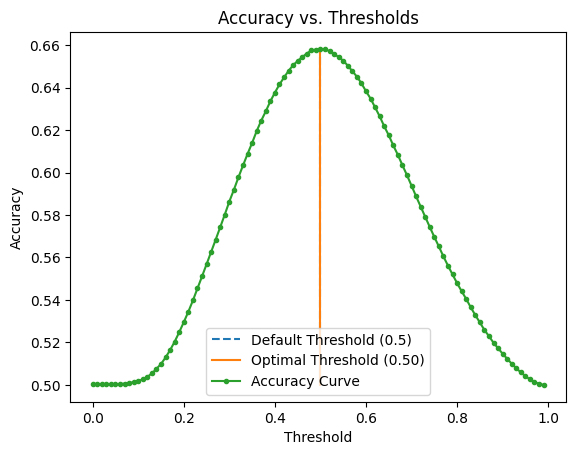

Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66    157229
           1       0.66      0.65      0.65    157344

    accuracy                           0.66    314573
   macro avg       0.66      0.66      0.66    314573
weighted avg       0.66      0.66      0.66    314573

Confusion Matrix with Optimal Threshold:
 [[105545  51684]
 [ 55830 101514]]


In [ ]:
# Predict probabilities
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracy for different thresholds
highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0, 1, 0.01)
scores = []

for t in thresholds:
    y_pred_custom = (y_pred_prob >= t).astype(int)
    score = accuracy_score(y_test, y_pred_custom)
    scores.append(score)
    if score > highest_accuracy:
        highest_accuracy = score
        threshold_highest_accuracy = t

print("Highest Accuracy on Test Set:", highest_accuracy)
print("Threshold for Highest Accuracy:", threshold_highest_accuracy)

# Plot accuracy vs. thresholds
plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle='--', label="Default Threshold (0.5)")
plt.plot([threshold_highest_accuracy, threshold_highest_accuracy], [np.min(scores), np.max(scores)], linestyle='-', label=f"Optimal Threshold ({threshold_highest_accuracy:.2f})")
plt.plot(thresholds, scores, marker='.', label="Accuracy Curve")
plt.title('Accuracy vs. Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model with the optimal threshold
y_pred_optimal = (y_pred_prob >= threshold_highest_accuracy).astype(int)

# Final evaluation metrics with the optimal threshold
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))


**F1 Tuning For XGBoost**

Highest F1 Score on Test Set: 0.6959773019957276
Threshold for Highest F1 Score: 0.36


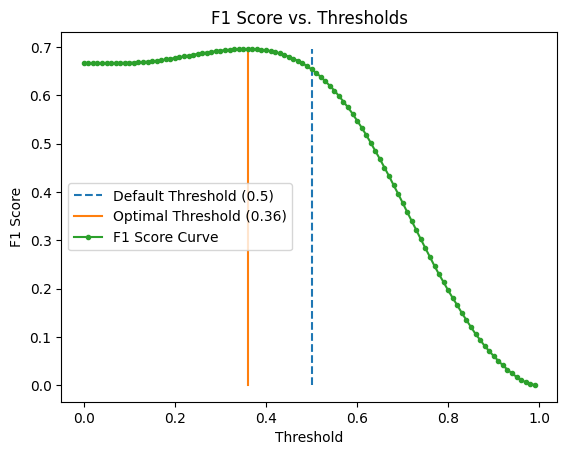

Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       0.74      0.37      0.49    157229
           1       0.58      0.87      0.70    157344

    accuracy                           0.62    314573
   macro avg       0.66      0.62      0.59    314573
weighted avg       0.66      0.62      0.59    314573

Confusion Matrix with Optimal Threshold:
 [[ 57882  99347]
 [ 20344 137000]]


In [ ]:
# Predict probabilities
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Calculate F1 score for different thresholds
highest_f1 = 0
threshold_highest_f1 = 0

thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_custom = (y_pred_prob >= t).astype(int)
    score = f1_score(y_test, y_pred_custom)
    f1_scores.append(score)
    if score > highest_f1:
        highest_f1 = score
        threshold_highest_f1 = t

print("Highest F1 Score on Test Set:", highest_f1)
print("Threshold for Highest F1 Score:", threshold_highest_f1)

# Plot F1 score vs. thresholds
plt.plot([0.5, 0.5], [np.min(f1_scores), np.max(f1_scores)], linestyle='--', label="Default Threshold (0.5)")
plt.plot([threshold_highest_f1, threshold_highest_f1], [np.min(f1_scores), np.max(f1_scores)], linestyle='-', label=f"Optimal Threshold ({threshold_highest_f1:.2f})")
plt.plot(thresholds, f1_scores, marker='.', label="F1 Score Curve")
plt.title('F1 Score vs. Thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Evaluate the model with the optimal threshold
y_pred_optimal = (y_pred_prob >= threshold_highest_f1).astype(int)

# Final evaluation metrics with the optimal threshold
print("Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix with Optimal Threshold:\n", confusion_matrix(y_test, y_pred_optimal))


# **Feature Importnace XGboost**


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:55:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6582224157826642
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.67      0.66    157229
           1       0.66      0.65      0.65    157344

    accuracy                           0.66    314573
   macro avg       0.66      0.66      0.66    314573
weighted avg       0.66      0.66      0.66    314573

Confusion Matrix:
 [[105545  51684]
 [ 55830 101514]]
Feature Importance:
                   Feature  Importance
2          DEP_TIME_START    0.253172
11                   PRCP    0.124591
4          SEGMENT_NUMBER    0.095957
0                   MONTH    0.075686
10              LONGITUDE    0.058220
12                   SNOW    0.049693
6         NUMBER_OF_SEATS    0.047482
9                LATITUDE    0.045942
13                   SNWD    0.045011
14                   TMAX    0.035981
3          DISTANCE_GROUP    0.035599
7   AIRPORT_FLIGHTS_MONTH    0.033636
1             DAY_OF_WEEK    0.032549
15           

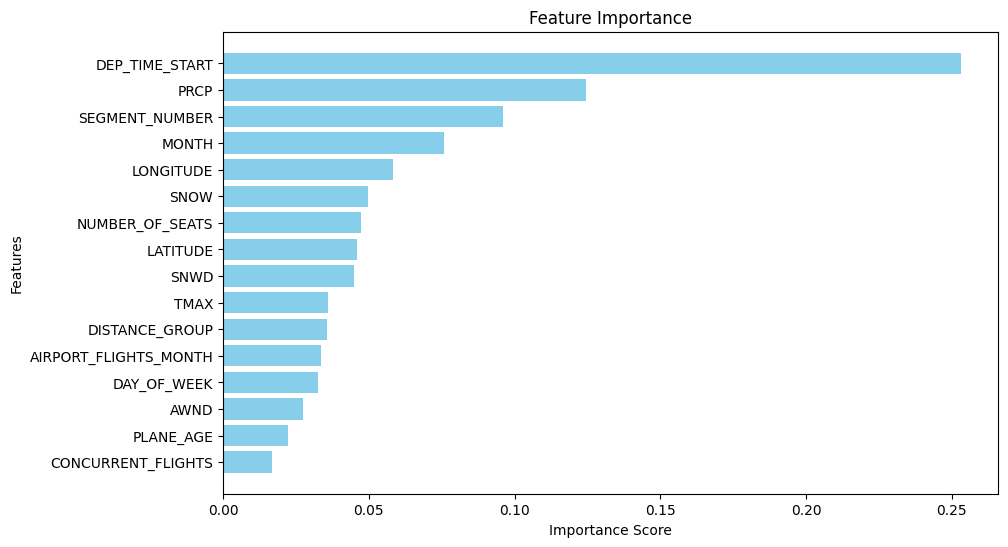

In [ ]:
# Preprocessing
df['DEP_TIME_START'] = df['DEP_TIME_BLK'].str.split('-').str[0].astype(int)

label_encoder = LabelEncoder()
df['CARRIER_NAME'] = label_encoder.fit_transform(df['CARRIER_NAME'])
df['DEPARTING_AIRPORT'] = label_encoder.fit_transform(df['DEPARTING_AIRPORT'])
df = df.dropna()

# Select features and target variable
X = df[['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_START', 'DISTANCE_GROUP',
        'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
        'AIRPORT_FLIGHTS_MONTH', 'PLANE_AGE', 'LATITUDE', 'LONGITUDE',
        'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']]
y = df['DEP_DEL15']

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model
model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Extract feature importance
feature_importance = model.feature_importances_

# Map feature importance to feature names
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:\n", importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


<Figure size 1000x800 with 0 Axes>

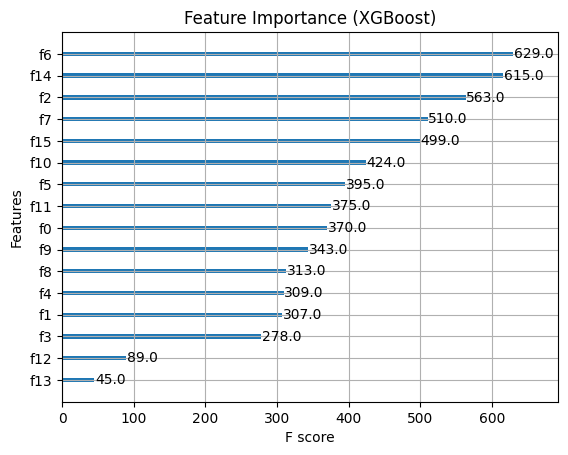

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight', title='Feature Importance (XGBoost)')
plt.show()


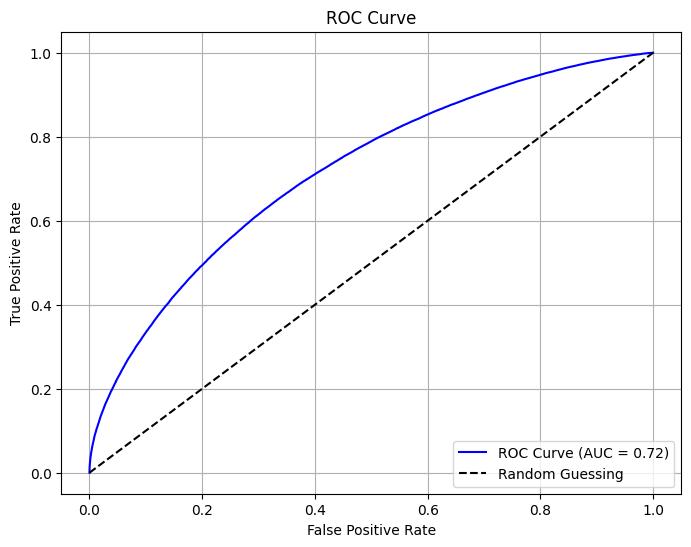

Area Under the Curve (AUC): 0.72


In [ ]:
# Get probabilities for the positive class
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print the AUC score
print(f"Area Under the Curve (AUC): {auc_score:.2f}")


# **Hyperparameter Optimisation for** **XGBoost**

In [ ]:
# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'objective': ['binary:logistic']
}

# Initialise the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Extract the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_classification_report = classification_report(y_test, y_pred_xgb)
xgb_confusion_matrix = confusion_matrix(y_test, y_pred_xgb)

# Display results
xgb_accuracy, xgb_classification_report, xgb_confusion_matrix


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:56:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

(0.6605366639857839,
 '              precision    recall  f1-score   support\n\n           0       0.66      0.68      0.67    157229\n           1       0.67      0.64      0.66    157344\n\n    accuracy                           0.66    314573\n   macro avg       0.66      0.66      0.66    314573\nweighted avg       0.66      0.66      0.66    314573\n',
 array([[106417,  50812],
        [ 55974, 101370]]))

**Best parameters**

In [ ]:
grid_search.best_params_

{'colsample_bytree': 1.0,
 'eta': 0.3,
 'max_depth': 7,
 'objective': 'binary:logistic',
 'subsample': 1.0}

In [ ]:
#Best grid search parameters
# {'colsample_bytree': 1.0,
#  'eta': 0.3,
#  'max_depth': 7,
#  'objective': 'binary:logistic',
#  'subsample': 1.0}

In [ ]:
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb = best_xgb_model.predict(X_test)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Accuracy: 0.6605366639857839
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.68      0.67    157229
           1       0.67      0.64      0.66    157344

    accuracy                           0.66    314573
   macro avg       0.66      0.66      0.66    314573
weighted avg       0.66      0.66      0.66    314573

Confusion Matrix:
 [[106417  50812]
 [ 55974 101370]]


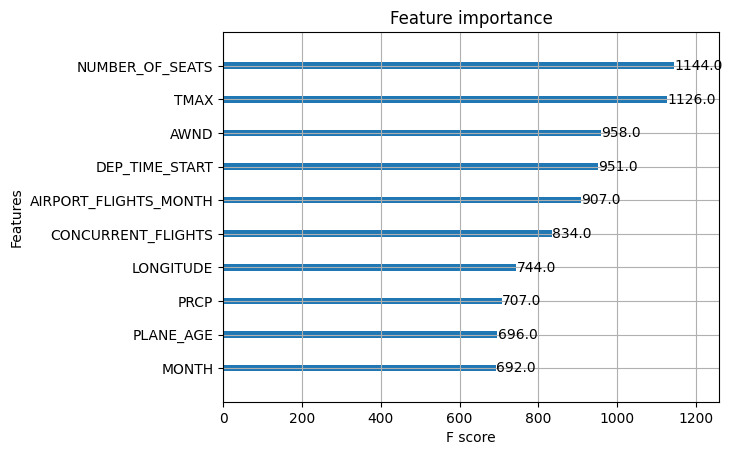

In [ ]:
xgb.plot_importance(best_xgb_model, max_num_features=10)
plt.show()

In [ ]:
y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)
print("Mean cross-validation accuracy:", scores.mean())

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:09:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-validation accuracy scores: [0.66017261 0.66041103 0.65894414 0.66050409 0.65985014]
Mean cross-validation accuracy: 0.6599764024745951


**ROC curve for XGBoost**

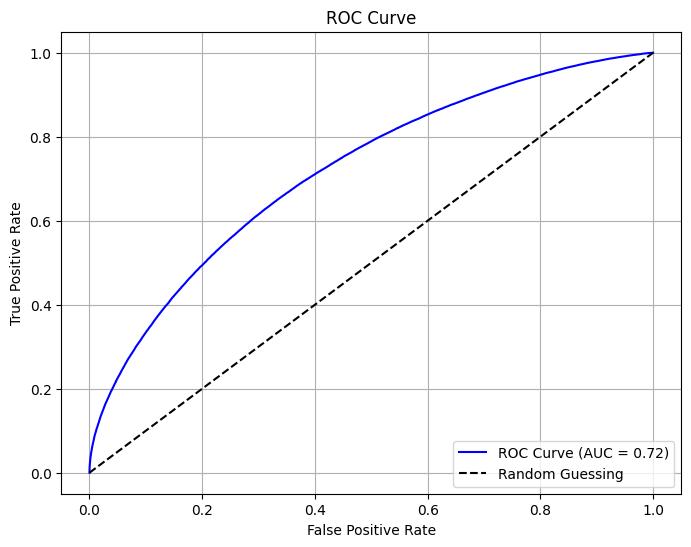

Area Under the Curve (AUC): 0.72


In [ ]:
# Get probabilities for the positive class
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print the AUC score
print(f"Area Under the Curve (AUC): {auc_score:.2f}")

# **Lasso predictive model**

In [ ]:
# Extract numeric time from 'DEP_TIME_BLK'
df['DEP_TIME_START'] = df['DEP_TIME_BLK'].str.split('-').str[0].astype(int)

# Convert categorical variables into numerical values
label_encoder = LabelEncoder()

# Example: Encoding 'CARRIER_NAME' and 'DEPARTING_AIRPORT'
df['CARRIER_NAME'] = label_encoder.fit_transform(df['CARRIER_NAME'])
df['DEPARTING_AIRPORT'] = label_encoder.fit_transform(df['DEPARTING_AIRPORT'])

# Handle missing values if any
df = df.dropna()

# Select features and target variable
X = df[['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_START', 'DISTANCE_GROUP',
        'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
        'AIRPORT_FLIGHTS_MONTH', 'PLANE_AGE', 'LATITUDE', 'LONGITUDE',
        'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']]

# Target variable
y = df['DEP_DEL15']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Lasso model
model = Lasso(alpha=1.0, random_state=42)  # Adjust alpha for regularisation strength
model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test_scaled)

# Evaluate model
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Squared Error (MSE): 0.2500005427914466
Mean Absolute Error (MAE): 0.5000002106781619
R² Score: -2.3048111186252385e-06


# **SVM**

In [ ]:
# Random Sample Taken
sample = df.sample(n=50000)

In [ ]:
# Verify features in sample
sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 179370 to 587100
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MONTH                          50000 non-null  int64  
 1   DAY_OF_WEEK                    50000 non-null  int64  
 2   DEP_DEL15                      50000 non-null  int64  
 3   DEP_TIME_BLK                   50000 non-null  object 
 4   DISTANCE_GROUP                 50000 non-null  int64  
 5   SEGMENT_NUMBER                 50000 non-null  int64  
 6   CONCURRENT_FLIGHTS             50000 non-null  int64  
 7   NUMBER_OF_SEATS                50000 non-null  int64  
 8   CARRIER_NAME                   50000 non-null  object 
 9   AIRPORT_FLIGHTS_MONTH          50000 non-null  int64  
 10  AIRLINE_FLIGHTS_MONTH          50000 non-null  int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  50000 non-null  int64  
 12  AVG_MONTHLY_PASS_AIRPORT       50000 non-null

In [ ]:
# Extract numeric time from 'DEP_TIME_BLK'
sample['DEP_TIME_START'] = df['DEP_TIME_BLK'].str.split('-').str[0].astype(int)

# Encode categorical features
label_encoder = LabelEncoder()
sample['CARRIER_NAME'] = label_encoder.fit_transform(sample['CARRIER_NAME'])
sample['DEPARTING_AIRPORT'] = label_encoder.fit_transform(sample['DEPARTING_AIRPORT'])

# Select features and target
X = sample[['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_START', 'DISTANCE_GROUP',
        'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
        'AIRPORT_FLIGHTS_MONTH', 'PLANE_AGE', 'LATITUDE', 'LONGITUDE',
        'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']]
y = sample['DEP_DEL15']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardise the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_report_svm = classification_report(y_test, y_pred_svm)
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Print results
print("SVM Model Accuracy:", accuracy_svm)
print("SVM Model Classification Report:\n", classification_report_svm)
print("SVM Model Confusion Matrix:\n", confusion_matrix_svm)

SVM Model Accuracy: 0.5962666666666666
SVM Model Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.57      0.59      7563
           1       0.59      0.62      0.61      7437

    accuracy                           0.60     15000
   macro avg       0.60      0.60      0.60     15000
weighted avg       0.60      0.60      0.60     15000

SVM Model Confusion Matrix:
 [[4298 3265]
 [2791 4646]]


# **Stacking Ensembele Model**

In [ ]:
# Preprocessing Steps
label_encoder = LabelEncoder()
sample['CARRIER_NAME'] = label_encoder.fit_transform(sample['CARRIER_NAME'])
sample['DEPARTING_AIRPORT'] = label_encoder.fit_transform(sample['DEPARTING_AIRPORT'])
sample['DEP_TIME_START'] = sample['DEP_TIME_BLK'].str.split('-').str[0].astype(int)
sample = sample.dropna()

# Feature Selection
X = sample[['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_START', 'DISTANCE_GROUP',
        'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
        'AIRPORT_FLIGHTS_MONTH', 'PLANE_AGE', 'LATITUDE', 'LONGITUDE',
        'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']]
y = sample['DEP_DEL15']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base Models
log_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svm_clf = SVC(probability=True, random_state=42)

# Meta-Model
final_estimator = LogisticRegression()

# Stacking Ensemble
estimators = [
    ('lr', log_clf),
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('dt', dt_clf),
    ('xgb', xgb_clf),
    ('svm', svm_clf)
]

stack_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)

# Train and Predict
stack_clf.fit(X_train_scaled, y_train)
y_pred = stack_clf.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:34:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:38:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:38:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6328666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64      7563
           1       0.63      0.63      0.63      7437

    accuracy                           0.63     15000
   macro avg       0.63      0.63      0.63     15000
weighted avg       0.63      0.63      0.63     15000



# **Deep Neural Network**

In [ ]:
# Preprocessing Steps
label_encoder = LabelEncoder()
df['CARRIER_NAME'] = label_encoder.fit_transform(df['CARRIER_NAME'])
df['DEPARTING_AIRPORT'] = label_encoder.fit_transform(df['DEPARTING_AIRPORT'])
df['DEP_TIME_START'] = df['DEP_TIME_BLK'].str.split('-').str[0].astype(int)
df = df.dropna()

# Feature Selection
X = df[['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_START', 'DISTANCE_GROUP',
        'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
        'AIRPORT_FLIGHTS_MONTH', 'PLANE_AGE', 'LATITUDE', 'LONGITUDE',
        'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']]
y = df['DEP_DEL15']

# One-hot encode target variable for neural network
y_nn = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_nn, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Deep Neural Network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Neural Network Accuracy:", accuracy)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22938/22938 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.6110 - loss: 0.6556 - val_accuracy: 0.6263 - val_loss: 0.6424
Epoch 2/20
22938/22938 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.6258 - loss: 0.6437 - val_accuracy: 0.6312 - val_loss: 0.6392
Epoch 3/20
22938/22938 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.6271 - loss: 0.6419 - val_accuracy: 0.6328 - val_loss: 0.6378
Epoch 4/20
22938/22938 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.6284 - loss: 0.6407 - val_accuracy: 0.6335 - val_loss: 0.6358
Epoch 5/20
22938/22938 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.6303 - loss: 0.6396 - val_accuracy: 0.6347 - val_loss: 0.6352
Epoch 6/20
22938/22938 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.6305 - loss: 0.6391 - val_accuracy: 0.6353 - val_loss: 0.6350
Epoch 7/20
22938/22938 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.6324 - loss: 0.6384 - val_accuracy: 0.6360 - val_loss: 0.6344
Epoch 8/20
22938/22938 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.6318 - lo